In [92]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw
from bw2data import parameters
from sympy.physics.units import years
from sympy.stats.crv_types import LogNormalDistribution
from sympy import init_printing
import lca_algebraic as agb
from dotenv import load_dotenv

# Custom utils defined for the parameterization
from lca_algebraic import *
from lca_algebraic.stats import *

# Pretty print for Sympy
init_printing()

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, expon, beta, uniform, triang, kstest

In [95]:
BW_PROJECT = 'lca_algebraic' # insert your project name here
bd.projects.set_current(BW_PROJECT)

EI_DB = 'ecoinvent-3.10-cutoff' # name of ecoinvent database in your project
# We use a separate DB for defining our foreground model / activities
USER_DB = "MyForeground"

In [96]:
# This is better to cleanup the whole foreground model each time, and redefine it in the notebook (or a python file)
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
agb.resetDb(USER_DB)

# Parameters are stored at project level : 
# Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
agb.resetParams()

# Overview of the databases
agb.list_databases()

,backend,nb_activities,type
name,,,
ecoinvent-3.10-biosphere,sqlite,4362,biosphere
ecoinvent-3.10-cutoff,sqlite,23523,background
,sqlite,0,foreground
MyForeground,sqlite,0,foreground


# Initial work

## Ore grade

Let's explore the distribution of values for ore grade for minerals for which we have data 

In [14]:
df_nickel = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2014_ni')
df_copper = pd.read_excel(r'data/data_metals_pellan.xlsx', sheet_name='Mudd2018_cop')

In [58]:
def plot_grade_statistics(df, grade_column, mineral, country=None):
    """
    Plots the distribution of ore grade data with key statistics for a specific mineral
    and returns a summary DataFrame with mean, min, max, and standard deviation.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - mineral (str): The mineral name (e.g., "Nickel" or "Copper").
    - country (str, optional): Specific country to filter the data by. Defaults to "All" if None.

    Returns:
    - pd.DataFrame: Summary of statistics including Mean, Min, Max, and Std Dev for the selected grade column.
    """
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    else:
        country = "All"  # Set country to "All" if no specific country is provided
    
    # Calculate statistics
    mean_val = df[grade_column].mean()
    min_val = df[grade_column].min()
    max_val = df[grade_column].max()
    std_dev = df[grade_column].std()

    # Create box plot to show the distribution of values
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[grade_column], color='skyblue')
    
    # Display min, max, mean, and std as horizontal lines
    plt.axhline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.4f}')
    plt.axhline(min_val, color='blue', linestyle='--', label=f'Min: {min_val:.4f}')
    plt.axhline(max_val, color='red', linestyle='--', label=f'Max: {max_val:.4f}')
    plt.axhline(mean_val + std_dev, color='purple', linestyle=':', label=f'Mean + Std Dev: {(mean_val + std_dev):.4f}')
    plt.axhline(mean_val - std_dev, color='purple', linestyle=':', label=f'Mean - Std Dev: {(mean_val - std_dev):.4f}')
    
    # Add title and labels
    plt.title(f'{mineral} - {grade_column} Distribution' + (f' for {country}' if country else ''))
    plt.xlabel('')
    plt.ylabel(grade_column)
    plt.legend()

    #plt.show()
    
    # Return summary statistics in a DataFrame
    summary_df = pd.DataFrame({
        'Mineral': [mineral],
        'Grade Column': [grade_column],
        'Country': [country],
        'Mean': [mean_val],
        'Min': [min_val],
        'Max': [max_val],
        'Std Dev': [std_dev]
    })
      
    return summary_df

,Mineral,Grade Column,Country,Mean,Min,Max,Std Dev
0,Nickel,Grade ResV,All,0.934864,0.015,3.99003,0.842238
1,Copper,Grade ResV,All,0.834055,0.004,7.92,0.907797
2,Nickel,Grade ResV,Canada,1.3424,0.0687193,2.78839,0.818872
3,Copper,Grade ResV,Canada,0.948472,0.03,7.92,1.31636


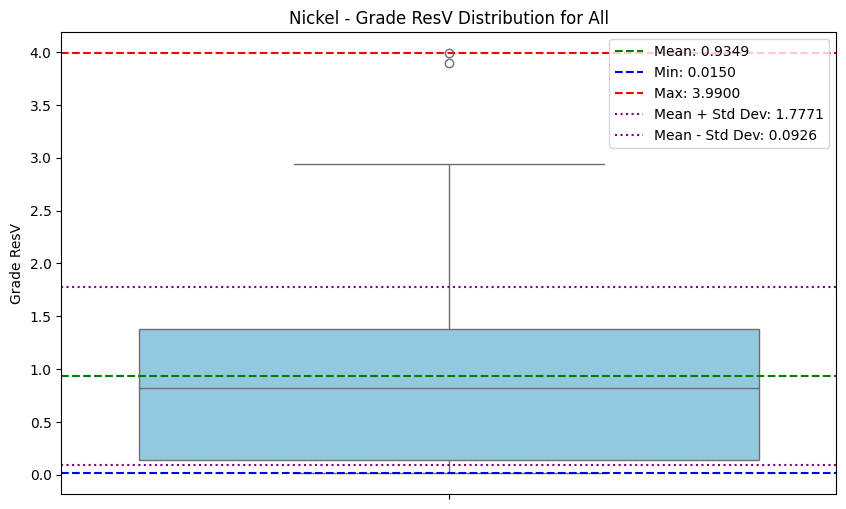

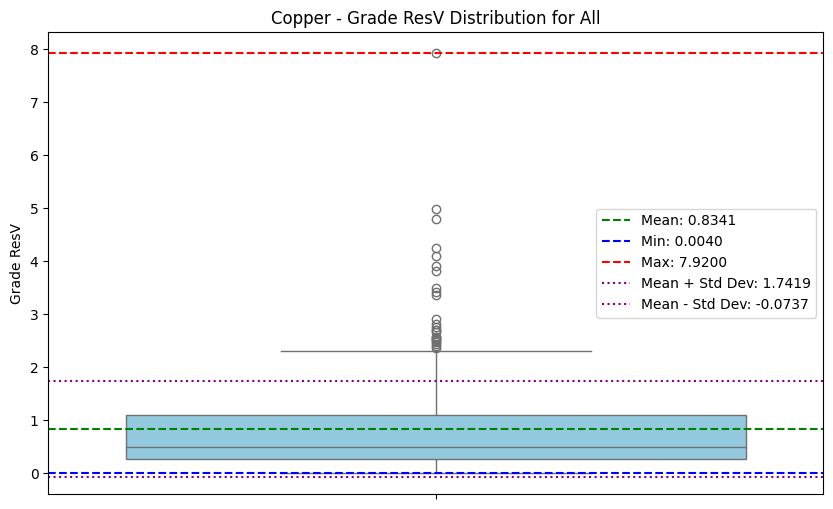

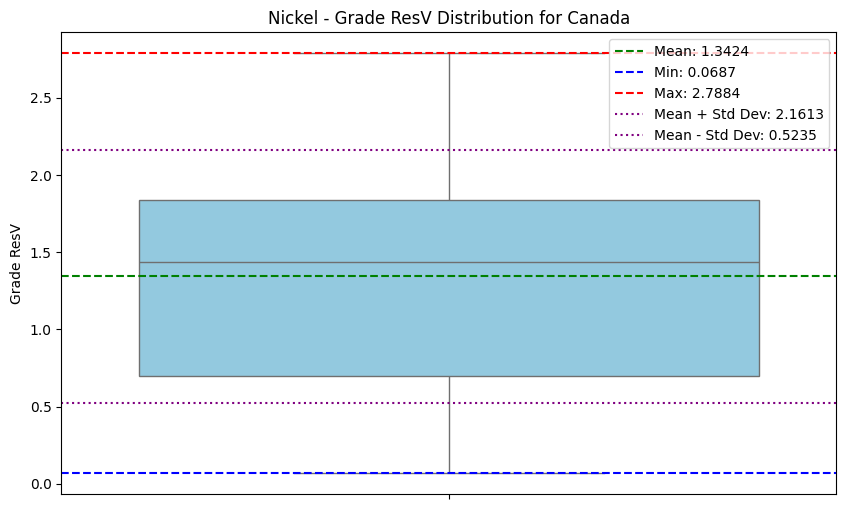

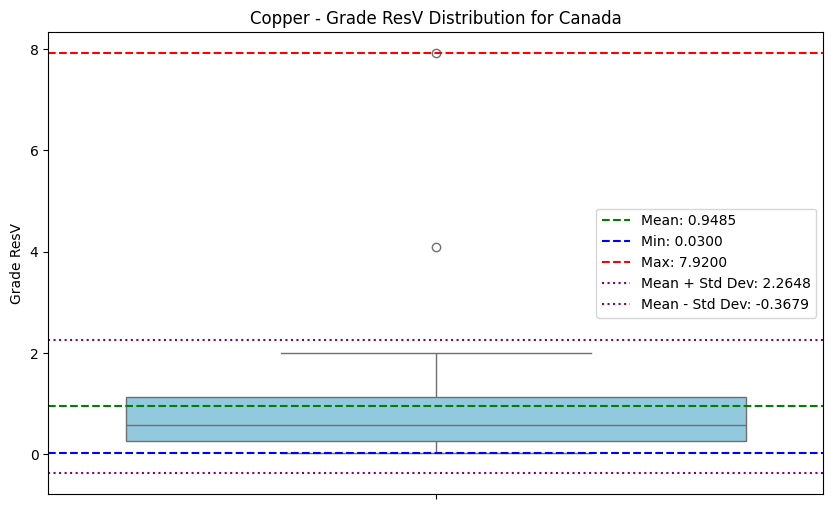

In [60]:
# Using the function for Nickel and Copper grades for all regions and Canada
nickel_resv = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel')
copper_resv = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper')
nickel_resv_can = plot_grade_statistics(df_nickel, 'Grade ResV', 'Nickel', country='Canada')
copper_resv_can = plot_grade_statistics(df_copper, 'Grade ResV', 'Copper', country='Canada')

# Concatenate dfs
og_stat = pd.concat([nickel_resv, copper_resv, nickel_resv_can,copper_resv_can ], ignore_index=True)

# Display the concatenated summary DataFrame
og_stat


In [61]:
# Storing each row in a dictionary for easy retrieval by mineral and region
ore_grade_stats = {}
for _, row in og_stat.iterrows():
    mineral = row['Mineral']
    region = row['Country']
    
    # Initialize dictionary for each mineral if not already present
    if mineral not in ore_grade_stats:
        ore_grade_stats[mineral] = {}
    
    # Store values for each region under the mineral key
    ore_grade_stats[mineral][region] = {
        'Mean': row['Mean'],
        'Min': row['Min'],
        'Max': row['Max'],
        'Std Dev': row['Std Dev']
    }

In [64]:
# Example usage to access values:
nickel_stats = ore_grade_stats['Nickel']['All']
nickel_stats

{'Mean': 0.9348643824454926,
 'Min': 0.015,
 'Max': 3.990033924698293,
 'Std Dev': 0.8422379199618545}

In [77]:
ni_mean = 0.934864
ni_min = 0.015
ni_max = 3.99003
ni_std = 0.842238

cu_mean = 0.834055
cu_min = 0.004
cu_max = 7.92
cu_std = 0.907797

In [78]:
ni_can_mean = 1.3424
ni_can_min = 0.0687193
ni_can_max = 2.78839
ni_can_std = 0.818872

cu_can_mean = 0.948472
cu_can_min = 0.03
cu_can_max = 7.92
cu_can_std = 1.31636

lca_algebraic supports seven distribution types: 
- Fixed 
- Uniform 
- Triangle
- Normal
- Log-normal
- Beta
- Statistic weight

In [34]:
# Adjust the function to skip beta fitting if data does not meet the requirement
def fit_and_test_distributions(df, grade_column, country=None, mineral=None):
    """
    Fits multiple theoretical distributions to the given ore grade data, 
    visualizes the data with a histogram and overlaid distribution curves, 
    and performs a Kolmogorov-Smirnov (K-S) test to assess the goodness of fit.

    Parameters:
    - df (pd.DataFrame): The dataset containing ore grade data.
    - grade_column (str): The column name for ore grade values.
    - country (str, optional): Specific country to filter the data by. If None, uses all data.

    Returns:
    - results (dict): A dictionary of K-S test results for each distribution, containing:
        - 'Statistic': The maximum difference between the empirical and theoretical cumulative distributions.
        - 'P-value': The probability that the sample data comes from the tested distribution.
        
    Notes:
    - Distributions tested include normal, log-normal, triangular, uniform, and beta (if data is within bounds).
    - Lower statistics and higher p-values indicate a better fit between the data and the tested distribution.
    """
     
    # Filter by country if specified
    if country:
        df = df[df['Country'] == country]
    
    # Drop NaN values and check if data is empty
    data = df[grade_column].dropna()
    if data.empty:
        print(f"No data available for {grade_column} in {country if country else 'all countries'}")
        return None
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=10, density=True, alpha=0.6, color='blue', label="Histogram")

    # Fit and plot normal distribution
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x, mu, std)
    plt.plot(x, p_norm, 'r-', label="Normal fit")

    # Fit and plot log-normal distribution
    shape, loc, scale = lognorm.fit(data, floc=0)
    p_lognorm = lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, p_lognorm, 'g-', label="Log-normal fit")

    # Fit and plot triangular distribution
    min_val, max_val = data.min(), data.max()
    most_likely = data.mean()  # Typically mean or mode for triangular
    c = (most_likely - min_val) / (max_val - min_val) if max_val != min_val else 0.5
    p_triang = triang.pdf(x, c, loc=min_val, scale=(max_val - min_val))
    plt.plot(x, p_triang, 'b-', label="Triangular fit")

    # Fit and plot uniform distribution
    p_uniform = uniform.pdf(x, loc=min_val, scale=max_val - min_val)
    plt.plot(x, p_uniform, 'm-', label="Uniform fit")

    # Store K-S test results for valid distributions
    results = {
        'Normal': kstest(data, 'norm', args=(mu, std)),
        'Log-normal': kstest(data, 'lognorm', args=(shape, loc, scale)),
        'Triangular': kstest(data, 'triang', args=(c, min_val, max_val - min_val)),
        'Uniform': kstest(data, 'uniform', args=(min_val, max_val - min_val))
    }

    # Attempt Beta fit, skip if data is outside 0-1 range after scaling
    try:
        a, b, loc, scale = beta.fit(data, floc=min_val, fscale=max_val - min_val)
        p_beta = beta.pdf(x, a, b, loc, scale)
        plt.plot(x, p_beta, 'y-', label="Beta fit")
        results['Beta'] = kstest(data, 'beta', args=(a, b, loc, scale))
    except ValueError:
        print(f"Skipping Beta fit for {grade_column} in {country if country else 'all countries'} (data out of bounds)")

    plt.title(f'{mineral} {grade_column} Distribution Fit' + (f' for {country}' if country else ''))
    plt.xlabel(grade_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return results

In [35]:
# Helper function to convert K-S test results into a DataFrame for easier analysis
def extract_results_to_df(results, mineral, grade_column, country=None):
    extracted_data = []
    for dist_name, result in results.items():
        extracted_data.append({
            'Mineral': mineral,
            'Grade Column': grade_column,
            'Country': country if country else 'All',
            'Distribution': dist_name,
            'Statistic': result.statistic,
            'P-value': result.pvalue
        })
    return pd.DataFrame(extracted_data)

Skipping Beta fit for Grade ResV in all countries (data out of bounds)


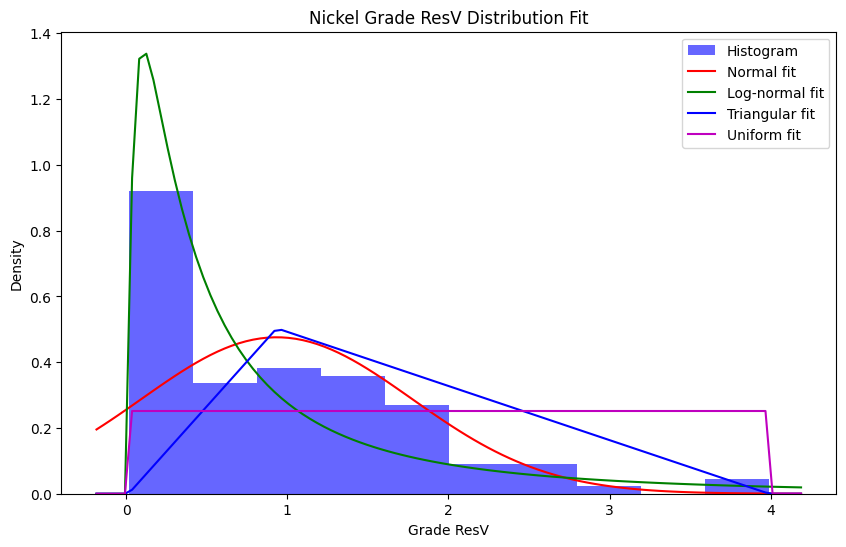

Skipping Beta fit for Grade ResV in all countries (data out of bounds)


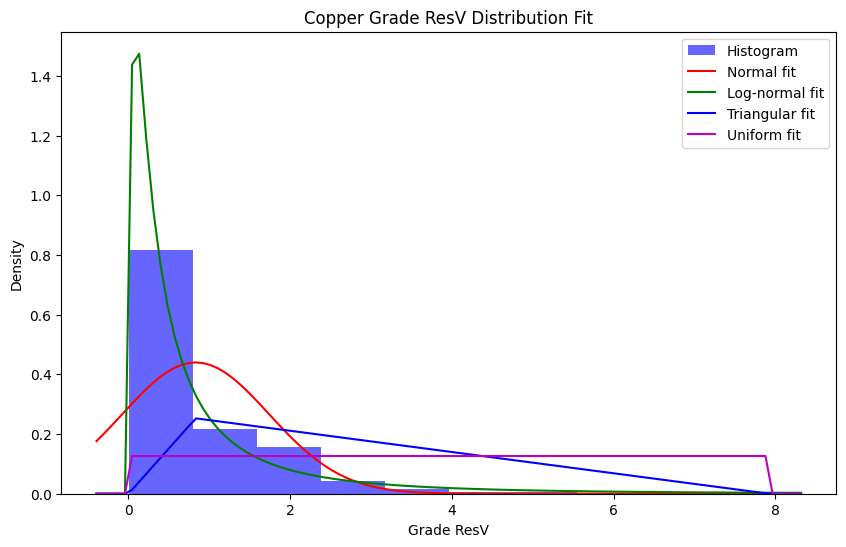

Skipping Beta fit for Grade ResV in Canada (data out of bounds)


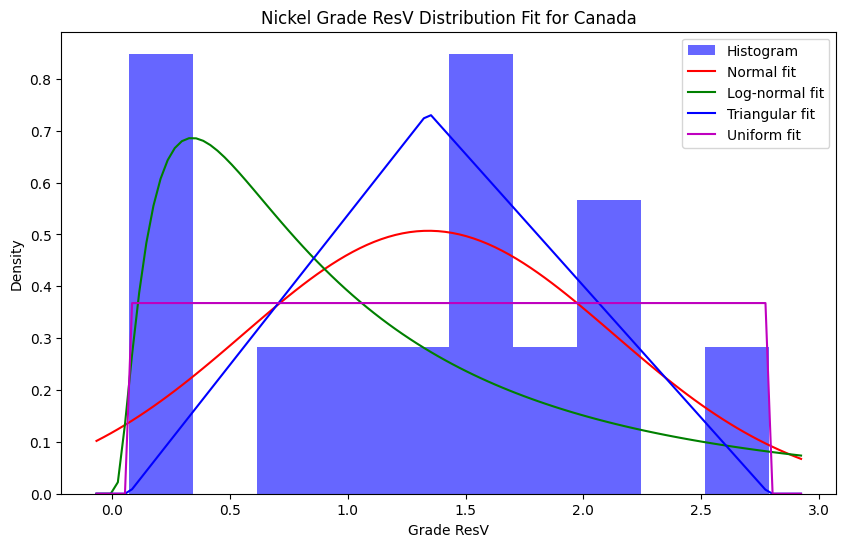

Skipping Beta fit for Grade ResV in Canada (data out of bounds)


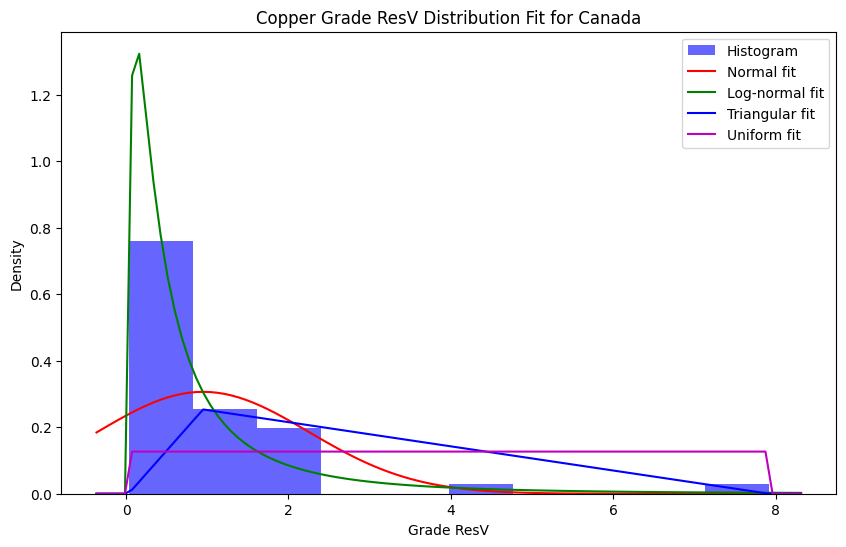

,Mineral,Grade Column,Country,Distribution,Statistic,P-value
0,Nickel,Grade ResV,All,Normal,0.136304,0.0281888
1,Nickel,Grade ResV,All,Log-normal,0.159576,0.00586203
2,Nickel,Grade ResV,All,Triangular,0.350509,8.31388e-13
3,Nickel,Grade ResV,All,Uniform,0.421113,1.60487e-18
4,Copper,Grade ResV,All,Normal,0.179968,5.26098e-12
5,Copper,Grade ResV,All,Log-normal,0.0985997,0.000676056
6,Copper,Grade ResV,All,Triangular,0.583438,3.58798e-132
7,Copper,Grade ResV,All,Uniform,0.652445,5.5929e-170
8,Nickel,Grade ResV,Canada,Normal,0.14392,0.915513
9,Nickel,Grade ResV,Canada,Log-normal,0.2597,0.291123


In [36]:
distrib_nickel_resv = fit_and_test_distributions(df_nickel, 'Grade ResV', mineral='Nickel')
distrib_copper_resv = fit_and_test_distributions(df_copper, 'Grade ResV', mineral='Copper')
distrib_nickel_resv_can = fit_and_test_distributions(df_nickel, 'Grade ResV', country="Canada", mineral='Nickel')
distrib_copper_resv_can = fit_and_test_distributions(df_copper, 'Grade ResV', country="Canada", mineral='Copper')

# Collect all results into DataFrames if results exist
results_dfs = []
if distrib_nickel_resv: results_dfs.append(extract_results_to_df(distrib_nickel_resv, 'Nickel', 'Grade ResV'))
if distrib_copper_resv: results_dfs.append(extract_results_to_df(distrib_copper_resv, 'Copper', 'Grade ResV'))
if distrib_nickel_resv_can: results_dfs.append(extract_results_to_df(distrib_nickel_resv_can, 'Nickel', 'Grade ResV', country='Canada'))
if distrib_copper_resv_can: results_dfs.append(extract_results_to_df(distrib_copper_resv_can, 'Copper', 'Grade ResV', country='Canada'))

# Combine all results into a single DataFrame
df_all_ks_test_results = pd.concat(results_dfs, ignore_index=True)
df_all_ks_test_results 

NormalDistribution (nickel) and LogNormalDistribution (copper) appear to be a good fit

In [68]:
# If log-normal distribution is chosen, we need those formulas to calculate the mean and std
cu_mean_log = np.log(cu_mean / np.sqrt(1 + (cu_std / cu_mean) ** 2))
cu_std_log = np.sqrt(np.log(1 + (cu_std / cu_mean) ** 2))
ni_mean_log = np.log(ni_mean / np.sqrt(1 + (ni_std / ni_mean) ** 2))
ni_std_log = np.sqrt(np.log(1 + (ni_std / ni_mean) ** 2))

# Defining input parameters

newFloatParam, newBoolParam, newEnumParam

## Mining phases

The following parameters are included:

- ore grade,
- mining technique mix (open cast, underground, ISL),
- tailings emissions,
- mining energy mix (diesel or electricity).

### Ore grade

Ore grade decline are observed for copper, zinc, lead and nickel in Van der Voet et al (2019). 10.1111/jiec.12722, who takes information from various sources (Mudd et al. (2017), Crowson (2012), Mudd & Jowit (2013), Northey et al. (2014) and Mudd et al. (2013)). The energy ore grade relation developed above defines how energy inputs change as a function of the
ore grade. Instead of developing a function for each individual input and output, we
assume that the energy change can serve as a proxy for the change of other inputs
and outputs. Thus, we model the effects of ore grade decline on the mining process
by applying the percentage energy change to all other input and output values. The only process affected by an ore grade decline is the metal mine operation.

- 1 - Definition of future ore grades G(t) and G(t0) for base years
- 2 - Definition of energy requirements E(G) based on the energy-ore relation from literature
- 3 - Calculate a percentage change p(t) between the base year and the future years
- 4 - Calculate modelling factor, which is applied to outflows of mining processes in ecoivent to model how inputs and outputs of mining processes change

- 1 - We first use a distribution to generate a set of possible ore grades. This distribution reflects uncertainty in the ore grade parameters
- 2 - We calculate the energy requirement for each sample based on the ore grade - energy requirement for each sample

In [107]:
# Float parameters 
ore_grade_copper = newFloatParam(
    'ore_grade_copper', 
    default=cu_mean,
    std= cu_std_log,
    min=cu_min,
    max=cu_max,
    unit='dimensionless',
    distrib=DistributionType.LOGNORMAL,
    description="Updated from statistical analysis of ore grade data from Mudd et al (2018)",
    label="Copper ore grade",
    dbname=USER_DB
)

ore_grade_nickel = newFloatParam(
    'ore_grade_nickel', 
    default=ni_mean,
    std= ni_std_log,
    min=ni_min,
    max=ni_max,
    unit='dimensionless',
    distrib=DistributionType.LOGNORMAL,
    description="Updated from statistical analysis of ore grade data from Mudd et al (2014)",
    label="Nickel ore grade",
    dbname=USER_DB
)

[WARNING] Warning : LogNormal does not support min/max boundaries for parameter :  ore_grade_copper
[WARNING] [ParamRegistry] Param ore_grade_copper was already defined in 'MyForeground' : overriding.
[WARNING] Warning : LogNormal does not support min/max boundaries for parameter :  ore_grade_nickel
[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.


# Tuto lca_algebraic

In [116]:
# Example of 'float' parameters
a = agb.newFloatParam(
    'a', 
    default=0.5, min=0.2, max=2,  
    distrib=agb.DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world",
    label="extended label for a")

b = agb.newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    distrib=agb.DistributionType.FIXED,
    description="foo bar")

share_recycled_aluminium = agb.newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, 
    min=0, max=1, std=0.2, 
    distrib=agb.DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

c = agb.newFloatParam(
    'c',  
    default=0.6, std=0.2, 
    distrib=agb.DistributionType.LOGNORMAL)

beta = agb.newFloatParam(
    'beta',  
    default=0.6, std=0.2, a=2, b=5, 
    distrib=agb.DistributionType.BETA)

In [117]:
# Enum parameters
# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = agb.newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = agb.newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of technology")

[WARNING] [ParamRegistry] Param elec_switch_param was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param techno_param was already defined in '<project>' : overriding.


In [118]:
# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = agb.newBoolParam(
    'bool_param', 
    default=1)

[WARNING] [ParamRegistry] Param bool_param was already defined in '<project>' : overriding.


In [119]:
# Load parameters previously  persisted in the dabatase.
agb.loadParams()

[WARNING] Warning : LogNormal does not support min/max boundaries for parameter :  ore_grade_copper
[WARNING] [ParamRegistry] Param ore_grade_copper was already defined in 'MyForeground' : overriding.
[WARNING] [ParamRegistry] Param ore_grade_copper was already defined in 'MyForeground' : overriding.
[WARNING] Variable 'ore_grade_copper' was already defined : overidding it with param.
[WARNING] Warning : LogNormal does not support min/max boundaries for parameter :  ore_grade_nickel
[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.
[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.
[WARNING] Variable 'ore_grade_nickel' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '

In [120]:
agb.setForeground(USER_DB)
agb.list_databases()

,backend,nb_activities,type
name,,,
ecoinvent-3.10-biosphere,sqlite,4362,biosphere
ecoinvent-3.10-cutoff,sqlite,23523,background
,sqlite,0,foreground
MyForeground,sqlite,0,foreground


In [121]:
# Save database and parameters as Bzipped JSON
agb.export_db(USER_DB, "data/db.bw2")

In [122]:
# Reimport DB
agb.import_db("data/db.bw2")

[WARNING] Warning : LogNormal does not support min/max boundaries for parameter :  ore_grade_copper
[WARNING] [ParamRegistry] Param ore_grade_copper was already defined in 'MyForeground' : overriding.
[WARNING] [ParamRegistry] Param ore_grade_copper was already defined in 'MyForeground' : overriding.
[WARNING] Variable 'ore_grade_copper' was already defined : overidding it with param.
[WARNING] Warning : LogNormal does not support min/max boundaries for parameter :  ore_grade_nickel
[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.
[WARNING] [ParamRegistry] Param ore_grade_nickel was already defined in 'MyForeground' : overriding.
[WARNING] Variable 'ore_grade_nickel' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] Variable 'a' was already defined : overidding it

Brightway2 SQLiteBackend: MyForeground

In [126]:
# Biosphere activities
ground_occupuation = agb.findBioAct('Occupation, industrial area') # Search by name
heat = agb.findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = agb.findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = agb.findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = agb.findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = agb.findTechAct("market group for electricity, medium voltage", 'US')

chromium = agb.findTechAct("market for chromium trioxide, flakes")

In [127]:
# Create a new activity
activity1 = agb.newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with an Enum parameter
elec_mix = agb.newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

[WARNING] Activity 'first foreground activity' was already in 'MyForeground'. Overwriting it
[WARNING] Activity 'elect mix' was already in 'MyForeground'. Overwriting it


In [128]:
# Copy and update existing activity
alu2 = agb.copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Aluminium 2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": agb.old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=chromium)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

In [129]:
total_inventory = agb.newActivity(USER_DB, "total_inventory", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

In [131]:
#Alternatively, you may not define the model again, but load it from the USER DB.

activity1 = agb.findActivity("first foreground activity", db_name=USER_DB)
total_inventory = agb.findActivity("total_inventory", db_name=USER_DB)
alu2 = agb.findActivity("Aluminium 2", db_name=USER_DB)

In [132]:
agb.printAct(activity1) 

first foreground activity (1.000000 kg)           \
                                                              input   amount   
Heat, waste                                             Heat, waste  b + 0.2   
Occupation, industrial area             Occupation, industrial area      3*b   

                                                
                                          unit  
Heat, waste                          megajoule  
Occupation, industrial area  square meter-year

In [133]:
agb.printAct(total_inventory)


total_inventory (1.000000 kg)  \
                                                                    input   
Aluminium 2                                          Aluminium 2[RER]{FG}   
aluminium alloy production, AlMg3  aluminium alloy production, AlMg3[RER]   
first foreground activity                   first foreground activity{FG}   

                                                                         
                                                       amount      unit  
Aluminium 2                        3*share_recycled_aluminium  kilogram  
aluminium alloy production, AlMg3                       0.4*a  kilogram  
first foreground activity                         a + 5*b + 1        kg

In [134]:
# You can also compute amounts by replacing parameters with a float value 
agb.printAct(activity1, b=1.5)

first foreground activity (1.000000 kg)  \
                                                              input   
Heat, waste                                             Heat, waste   
Occupation, industrial area             Occupation, industrial area   

                                                                  
                                       amount               unit  
Heat, waste                  1.70000000000000          megajoule  
Occupation, industrial area  4.50000000000000  square meter-year

In [135]:
# You can print several activities at once to compare them
agb.printAct(alu, alu2)

In [136]:
# List of impacts to consider
impacts = agb.findMethods("climate change", mainCat="EF v3.0")
impacts

[('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'climate change: land use and land use change',
  'global warming potential (GWP100)')]

In [137]:
# FU can be parametrized
functional_value = a + 5

In [139]:
agb.list_databases()


,backend,nb_activities,type
name,,,
ecoinvent-3.10-biosphere,sqlite,4362,biosphere
ecoinvent-3.10-cutoff,sqlite,23523,background
,sqlite,0,foreground
MyForeground,sqlite,7,foreground


In [138]:
agb.compute_impacts(
    
    # Root activity of our inventory
    total_inventory, 
    
    # list of impacts to consider
    impacts, 
    
    # The impaxts will be divided by the functional unit
    functional_unit=functional_value,
    
    # Parameters of the model
    a=1.0,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

UnknownObject: Exchange between ('', 'testing ore grade') and ('', 'testing ore grade') is invalid - one of these objects is unknown (i.e. doesn't exist as a process dataset)

In [140]:
# You can compute several LCAs at a time and compare them:
agb.compute_impacts(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

[INFO] Db changed recently, clearing cache expr


UnknownObject: Exchange between ('', 'testing ore grade') and ('', 'testing ore grade') is invalid - one of these objects is unknown (i.e. doesn't exist as a process dataset)

In [141]:
# Fast computation for millions of separate samples
agb.compute_impacts(
    total_inventory, # The model 
    impacts, # Impacts
    functional_unit = functional_value,
    
    # Parameters of the model
    a=list(range(1, 100000)), # All lists should have the same size
    share_recycled_aluminium=1, # Those parameters are fixed
    elec_switch_param="eu")

UnknownObject: Exchange between ('', 'testing ore grade') and ('', 'testing ore grade') is invalid - one of these objects is unknown (i.e. doesn't exist as a process dataset)

It is possible to **tag** activities and then ventilate the impacts according to the value of this "tag".
This is useful to split impact by *phase* or *sub module*.

In [142]:
# Tag activities with a custom attribute : 'phase' in this case
alu2.updateMeta(phase= "phase a")
activity1.updateMeta(phase= "phase b")

In [143]:
# Provide the name of the custom attribute as 'axis'
# The impacts are split between those
agb.compute_impacts(
    total_inventory, # The model
    impacts, # Impacts
    
    functional_unit = functional_value,
    axis="phase",

    
    # Parameters
    a=1.0,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

[INFO] Db changed recently, clearing cache expr


UnknownObject: Exchange between ('', 'testing ore grade') and ('', 'testing ore grade') is invalid - one of these objects is unknown (i.e. doesn't exist as a process dataset)

### Mining techniques

In [ ]:
mining_shares = {'open_pit':.161/.935,
                'underground':.200/.935,
                'ISL':0.574/.935}

### Mining energy mix

In [ ]:
mining_energy_shares = {'diesel':0.3,
                        'electricity':0.7}

In [ ]:
# Total energy for extraction : where does that come from ???

a_op = 274
b_op = -0.482

a_ug = 317
b_ug = -0.176

a_is = 220
b_is = -0.0485

extraction_energy_open_pit = a_op * exp(b_op * ore_grade) / recovery_rate
extraction_energy_underground = a_ug * exp(b_ug * ore_grade) / recovery_rate
extraction_energy_ISL = a_is * exp(b_is * ore_grade) / recovery_rate

In [ ]:
mining_electricity_switch = newEnumParam(
    'mining_electricity_switch', 
    label='Mining electricity, grid or diesel',
    values=['dieselgenerator',
            'grid'], # You can provide a statistical weight for each value, by using a dict
    default='dieselgenerator', 
    description="Choice of electricity source for mining",
    dbname=USER_DB)

### Emissions

In [12]:
# Emissions of radon-222 from tailings
tailings_Rn222 = newFloatParam(
    'tailings_Rn222', 
    default=0.01951, min=0.01, max=1,
    distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="Rn222 from tailings, in Bq/s",
    label="Rn222 from tailings, in Bq/s",
    unit='Bq/s',
    dbname=USER_DB)

NameError: name 'USER_DB' is not defined

## Concentration phase 

The following parameters are included:

- xxx


In [ ]:
# Conversion phase, heat consumption
conversion_heat = newFloatParam(
    'conversion_heat', 
    default=26, min=26, max=665,
    distrib=DistributionType.TRIANGLE,
    label='Conversion heat input',
    unit='kWh/kg U in UF6',
    description="Heat required to convert 1 kg of UF6",
    dbname=USER_DB)

## Refining stage 

### List of all parameters 

In [ ]:
list_parameters() # recap of all parameters declared in the model 

In [ ]:
# And because a figure is worth 1000 words
utils._plot_params([p for p in params._param_registry().all() if p.distrib in ['linear', 'triangle', 'lognormal']], columns=5, size=2000, figsize=(16,9))
plt.savefig('output/parameters.svg')

# Transforming and updating parametrized inventories

In [ ]:
# Mining and milling
tailings         = findActivity('Tailing, from uranium milling, WNA', loc='EUR', db_name='UNEP_IRP_EUR')
open_pit         = findActivity('Uranium mine operation, open cast, WNA', loc='GLO', db_name='UNEP_IRP_EUR')
underground      = findActivity('Uranium mine operation, underground, WNA', loc='GLO', db_name='UNEP_IRP_EUR')
ISL              = findActivity('Uranium mine operation, in-situ leaching, WNA', loc='GLO', db_name='UNEP_IRP_EUR')

In [ ]:
# Copy to preserve the non-parametrized inventories 
open_pit_p = copyActivity(
    USER_DB,
    open_pit,
    'Uranium mine operation, open cast, parameterized')

In [ ]:
# We replace fixed values by parameters in the LCI 
# Mining techniques, 3 activities
open_pit_p.updateExchanges({
    # This is electricity
    'market for diesel, burned in diesel-electric generating set, 10MW*': dict(amount=mining_energy_shares['electricity'] * extraction_energy_open_pit,
                                                                              input=mining_elec_mix),
    # This is diesel used as fuel
    'market for diesel, burned in building machine*': mining_energy_shares['diesel'] * extraction_energy_open_pit
}
)

In [ ]:
# Update inventories 